In [1]:
import numpy as np
from pyproj import Proj, transform
from scipy.interpolate import griddata
p1 = Proj("+proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +towgs84=565.237,50.0087,465.658,-0.406857,0.350733,-1.87035,4.0812 +units=m +no_defs")
p2 = Proj(proj='latlong',datum='WGS84')

import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib notebook
import os
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from netCDF4 import Dataset, num2date


In [2]:
directory  = 'D:/Use_case_Schouwen/'
name_baty  = 'suppletie 5_1.XYZ'
name_baty2 = 'suppletie 5_2.XYZ'

nodes = np.loadtxt('D:/Use_case_Schouwen/tidal_an/nodes.csv')

In [3]:
coords_RD1 = np.loadtxt(directory + name_baty, dtype= float)
coords_RD2 = np.loadtxt(directory + name_baty2, skiprows=1, dtype= float)
coords_RD = np.concatenate((coords_RD1, coords_RD2))
coords_RD[:,2] = coords_RD[:,2] / 100

In [4]:
coords_WGS = []
for C in coords_RD:
    lon, lat, z = transform(p1, p2, C[0], C[1], C[2])
    coords_WGS.append([lon, lat, z])
    
coords_WGS = np.array(coords_WGS)
coords_WGS[:,2] = coords_RD[:,2]

# nc = Dataset('D:/DCSMv6-ZUNOv4/E5_2018.dtm') # source https://maps.ngdc.noaa.gov/viewers/bathymetry/
# A = 0
# B = 300
# C = -900
# D = -600

# lon = nc.variables['COLUMNS'][A:B]
# lat = nc.variables['LINES'][C:D]
# lon, lat = np.meshgrid(lon, lat)
# bat = nc.variables['DEPTH_SMOOTH'][C:D,A:B]

# lon2 = lon.reshape(lon.size)
# lat2 = lat.reshape(lon.size)
# bat2 = bat.reshape(lon.size)

# extra_pnts  = np.zeros((lon2.shape[0],3))
# extra_pnts[:,0] = lon2 
# extra_pnts[:,1] = lat2 
# extra_pnts[:,2] = bat2 

# coords_WGS = np.concatenate((coords_WGS, extra_pnts))

In [5]:
class LineBuilder: 
    def __init__(self, line):
        self.line = line
        self.xs = []
        self.ys = []
        self.cid = line.figure.canvas.mpl_connect('button_press_event', self)
        self.nodes = []

    def __call__(self, event):
        print('click', event)
        if event.inaxes!=self.line.axes: return
        self.xs.append(event.xdata)
        self.ys.append(event.ydata)
        self.line.set_data(self.xs, self.ys)
        self.line.figure.canvas.draw()
        self.nodes.append((event.xdata, event.ydata))
        
        
D_emp = 4.0
D_full = 5.0
ukc = 1.0
tide = -1.5

N = 300
start = [3.676014309976414,51.71540093282213]
stop = [3.522637481591586,51.76880095558772]

x_r = np.arange(3.5 ,3.72, (-3.66+3.72)/N)
y_r = np.arange(51.6,51.8, (-51.66+51.71)/N)
y_r, x_r = np.meshgrid(y_r,x_r)

WD_r = tide -  griddata(coords_WGS[:,:2], coords_WGS[:,2], (x_r, y_r), method= 'linear')

<IPython.core.display.Javascript object>


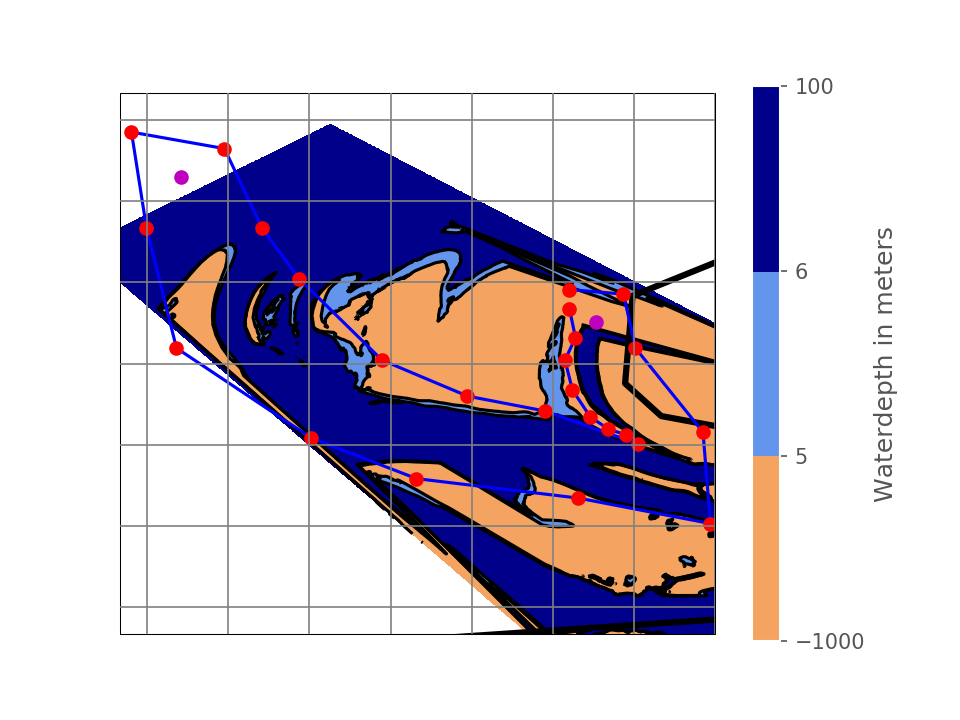

In [9]:
% matplotlib notebook

fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())

cval = [-1000,D_emp +ukc, D_full+ukc, 100]
im = plt.contourf(x_r,y_r,WD_r,cval,transform=ccrs.PlateCarree(), colors = ('sandybrown', 'cornflowerblue', 'darkblue'))
fig.colorbar(im, ax=ax, label = 'Waterdepth in meters')

cval2 = [D_emp+ukc, D_full+ukc]
plt.contour(x_r,y_r,WD_r,cval2,transform=ccrs.PlateCarree(), colors = 'black')

ax.coastlines(resolution='10m', color='black', linewidth=3)
ax.gridlines(color = 'grey', zorder = 3)

# plt.plot(coords_WGS[:,0], coords_WGS[:,1], 'r.',markersize = 0.2,transform=ccrs.PlateCarree())
# plt.plot(nodes[:,1], nodes[:,0], 'r.',transform=ccrs.PlateCarree())
plt.plot(start[0], start[1],'mo',transform=ccrs.PlateCarree())
plt.plot(stop[0], stop[1], 'mo',transform=ccrs.PlateCarree() )
# plt.plot(3.67074012, 51.70969009,'ro', transform=ccrs.PlateCarree())
ax.set_extent([3.5 ,3.72,51.6,51.8])

line, = plt.plot([], [], 'b')
points, = plt.plot([],[], 'ro')
linebuilder = LineBuilder(line)
pointbuilder = LineBuilder(points)


plt.show()

# add_nodes = linebuilder.nodes

In [10]:
add_nodes = linebuilder.nodes

np.savetxt('additional_nodes2.csv', add_nodes)